# SD212: Graph mining
## Lab 4: Graph clustering

In this lab, you will learn to cluster a graph and interpret the results. 

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse

In [9]:
!pip install scikit-network --upgrade --user

Requirement already up-to-date: scikit-network in /Users/eric/anaconda3/lib/python3.7/site-packages (0.18.0)


In [3]:
from sknetwork.utils import membership_matrix, directed2undirected, Bunch
 
def grid(n1: int = 10, n2: int = 10, metadata: bool = False):
    """Grid (undirected).
    Parameters
    ----------
    n1, n2 : int
        Grid dimension.
    metadata : bool
        If ``True``, return a `Bunch` object with metadata.
    Returns
    -------
    adjacency or graph : Union[sparse.csr_matrix, Bunch]
        Adjacency matrix or graph with metadata (positions).
    Example
    -------
    >>> from sknetwork.data import grid
    >>> adjacency = grid(10, 5)
    >>> adjacency.shape
    (50, 50)
    """
    nodes = [(i1, i2) for i1 in range(n1) for i2 in range(n2)]
    edges = [((i1, i2), (i1 + 1, i2)) for i1 in range(n1 - 1) for i2 in range(n2)]
    edges += [((i1, i2), (i1, i2 + 1)) for i1 in range(n1) for i2 in range(n2 - 1)]
    node_id = {u: i for i, u in enumerate(nodes)}
    edges = list(map(lambda edge: (node_id[edge[0]], node_id[edge[1]]), edges))
    adjacency = edgelist2adjacency(edges, undirected=True)
    if metadata:
        graph = Bunch()
        graph.adjacency = adjacency
        graph.position = np.array(nodes)
        return graph
    else:
        return adjacency

In [4]:
def edgelist2adjacency(edgelist: list, undirected: bool = False) -> sparse.csr_matrix:
    """Build an adjacency matrix from a list of edges.
    Parameters
    ----------
    edgelist : list
        List of edges as pairs (i, j) or triplets (i, j, w) for weighted edges.
    undirected : bool
        If ``True``, return a symmetric adjacency.
    Returns
    -------
    adjacency : sparse.csr_matrix
    Examples
    --------
    >>> edgelist = [(0, 1), (1, 2), (2, 0)]
    >>> adjacency = edgelist2adjacency(edgelist)
    >>> adjacency.shape, adjacency.nnz
    ((3, 3), 3)
    >>> adjacency = edgelist2adjacency(edgelist, undirected=True)
    >>> adjacency.shape, adjacency.nnz
    ((3, 3), 6)
    >>> weighted_edgelist = [(0, 1, 0.2), (1, 2, 4), (2, 0, 1.3)]
    >>> adjacency = edgelist2adjacency(weighted_edgelist)
    >>> adjacency.dtype
    dtype('float64')
    """
    edges = np.array(edgelist)
    row, col = edges[:, 0].astype(np.int32), edges[:, 1].astype(np.int32)
    n = max(row.max(), col.max()) + 1
    if edges.shape[1] > 2:
        data = edges[:, 2]
    else:
        data = np.ones_like(row, dtype=bool)
    adjacency = sparse.csr_matrix((data, (row, col)), shape=(n, n))
    if undirected:
        adjacency = directed2undirected(adjacency)
    return adjacency

In [5]:
# if you get any error, please update scikit-network!
#from sknetwork.data import load_netset, grid, karate_club
from sknetwork.data import load_netset, karate_club
from sknetwork.clustering import Louvain, BiLouvain, modularity
from sknetwork.ranking import PageRank, BiPageRank, top_k
from sknetwork.linalg import normalize
from sknetwork.utils import membership_matrix
from sknetwork.visualization import svg_graph, svg_digraph

## Data

We will work on the following graphs (see the [NetSets](https://graphs.telecom-paristech.fr/Home_page.html#netsets-section) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [6]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')
cinema = load_netset('cinema')

## 1. Graphs

The Louvain algorithm aims at maximizing [modularity](https://en.wikipedia.org/wiki/Modularity_(networks)).

## Grid

Consider a grid:

In [14]:
graph = grid(9, 9, True)
adjacency = graph.adjacency
position = graph.position

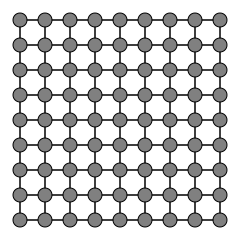

In [15]:
image = svg_graph(adjacency, position, width=200, height=200)
SVG(image)

## To do

* Cluster the graph by Louvain and display it with the labels.
* What is the modularity?
* Try the ``shuffle_nodes`` option and observe the results.
* Find a better clustering than Louvain in terms of modularity. **Hint:** Guess and calculate!

In [16]:
louvain = Louvain()

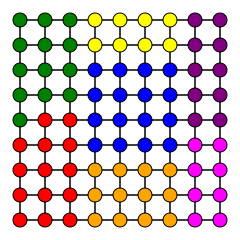

In [17]:
labels = louvain.fit_transform(adjacency)
image = svg_graph(adjacency, position, labels=labels, width=200, height=200)
SVG(image)

In [18]:
modularity(adjacency,labels)

0.6220341435185185

In [19]:
# With shuffle_nodes
louvain = Louvain(shuffle_nodes=True)
labels = louvain.fit_transform(adjacency)
modularity(adjacency,labels)

0.6277729552469136

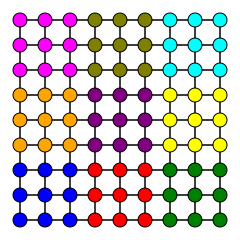

In [20]:
# Example to find the best modularity (it can be not the best one)
n = adjacency.shape[0]
labels = np.array([((i%9)//3)*3+(i//9)//3 for i in range(n)])
image = svg_graph(adjacency, position, labels=labels, width=200, height=200)
SVG(image)

In [21]:
modularity(adjacency, labels)

0.638454861111111

## Karate Club


The [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) provides ground-truth clusters.

In [7]:
graph = karate_club(True)

In [8]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels

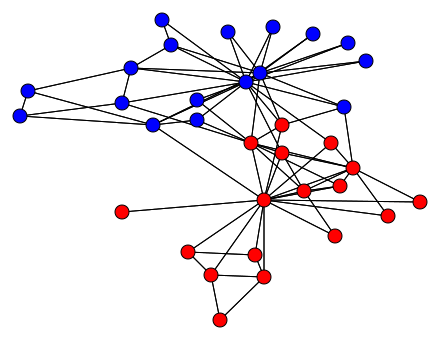

In [9]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Cluster the graph by Louvain and display the labels.
* What is the modularity?
* Display the aggregate graph.
* Adapt the resolution to get 2 clusters. How many nodes are misclassified?

In [10]:
louvain = Louvain()

In [11]:
labels = louvain.fit_transform(adjacency)

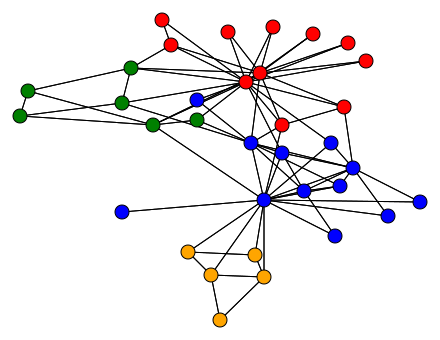

In [12]:
image = svg_graph(adjacency, position, labels=labels)
SVG(image)

In [13]:
modularity(adjacency,labels)

0.4188034188034188

In [14]:
adjacency_aggregate = louvain.adjacency_

In [15]:
average = normalize(membership_matrix(labels).T)
position_aggregate = average.dot(position)

In [16]:
labels_unique, counts = np.unique(labels, return_counts=True)

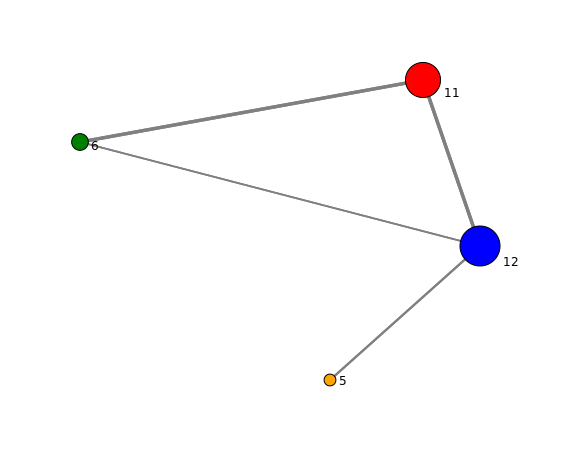

In [17]:
image = svg_graph(adjacency_aggregate, position_aggregate, names=counts, labels=labels_unique, display_node_weight=True)
SVG(image)

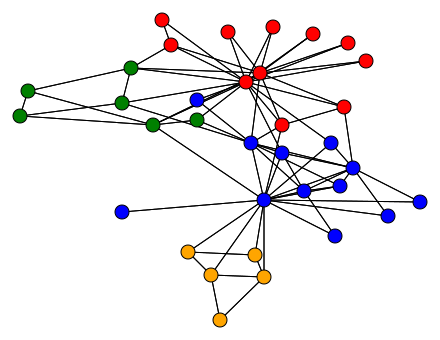

In [18]:
# With Resolution 
louvain = Louvain(resolution=1)
labels = louvain.fit_transform(adjacency)
image = svg_graph(adjacency, position, labels=labels)
SVG(image)
# 2 misclassified nodes

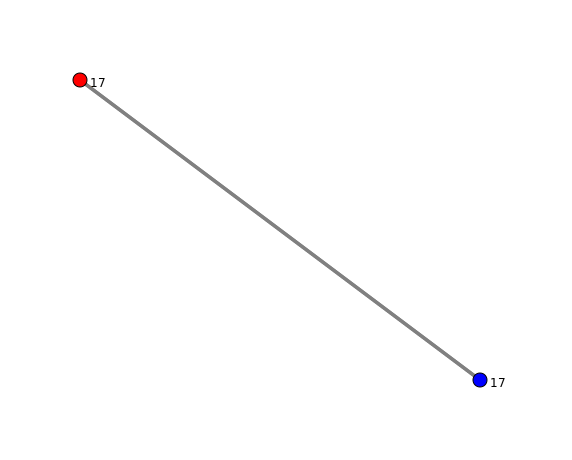

In [34]:
# Aggregate with resolution
adjacency_aggregate = louvain.adjacency_
average = normalize(membership_matrix(labels).T)
position_aggregate = average.dot(position)
labels_unique, counts = np.unique(labels, return_counts=True)
image = svg_graph(adjacency_aggregate, position_aggregate, names=counts, labels=labels_unique, display_node_weight=True)
SVG(image)

## Openflights


In [35]:
graph = openflights

In [36]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

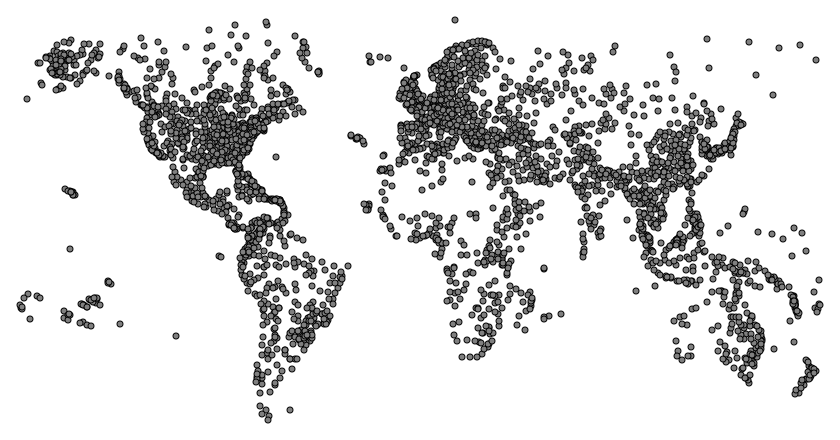

In [37]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the clusters found by Louvain (resolution 1).
* How many clusters are there?
* What is the Simpson index of this clustering? Check the parameters of the function ``modularity``.
* How do you interpret the *inverse* of the Simpson index?
* List the top airport of each cluster in number of flights.
* Display the aggregate graph with the cluster volumes and the name of the top airport of each cluster.
* What is the strongest cluster among those having more than 100 nodes? **Hint:** Use the aggregate graph.

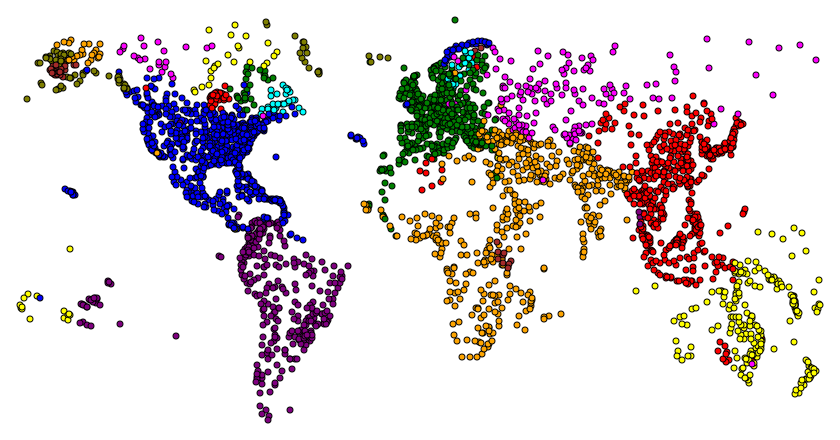

In [38]:
louvain = Louvain()
labels = louvain.fit_transform(adjacency)
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, labels=labels, display_edges=False)
SVG(image)

In [39]:
labels_unique, counts = np.unique(labels, return_counts=True)
print("There are " ,len(labels_unique), " clusters")

There are  35  clusters


In [40]:
modularity(adjacency, labels, return_all= True)

(0.6547379865067756, 0.8702285399178972, 0.21549055341112153)

In [41]:
airports = []
for i in labels_unique:
    tot = np.sum(adjacency, axis=1)
    idx = np.where(labels==i)[0]
    m = np.argmax(tot[idx])
    airports.append(idx[m])

In [42]:
names[airports]

array(['Hartsfield Jackson Atlanta International Airport',
       'Beijing Capital International Airport',
       'Amsterdam Airport Schiphol', 'Atatürk International Airport',
       'Guarulhos - Governador André Franco Montoro International Airport',
       'Sydney Kingsford Smith International Airport',
       'Domodedovo International Airport',
       'Ted Stevens Anchorage International Airport',
       'Quebec Jean Lesage International Airport', 'Bethel Airport',
       'Trondheim Airport Værnes', 'Sioux Lookout Airport',
       'Kuujjuarapik Airport', 'Fairbanks International Airport',
       "Faa'a International Airport", 'Rankin Inlet Airport',
       'Yellowknife Airport', 'Godthaab / Nuuk Airport',
       'Stockholm-Bromma Airport', 'Nairobi Wilson Airport',
       'João Paulo II Airport',
       'Touat Cheikh Sidi Mohamed Belkebir Airport', 'Kirkwall Airport',
       'Sitia Airport', 'Myeik Airport', 'Eilat Airport',
       'Vilhelmina Airport', 'Golfito Airport', 'Pori Air

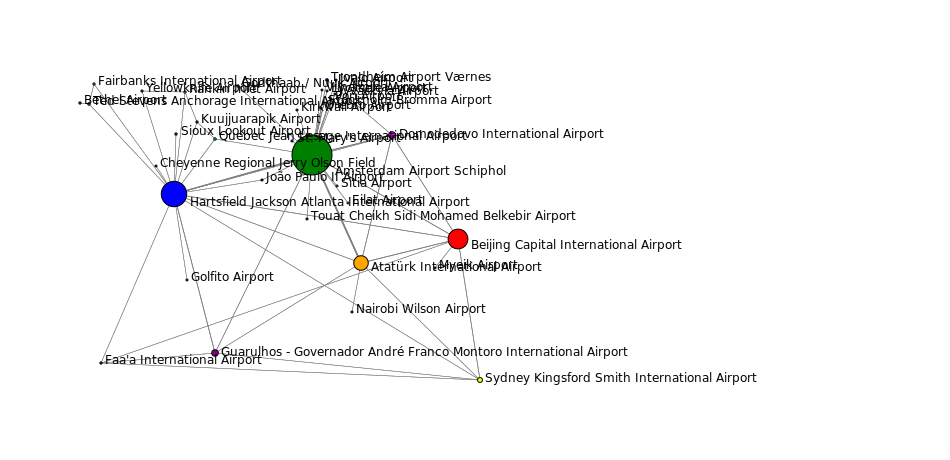

In [43]:
adjacency_aggregate = louvain.adjacency_
average = normalize(membership_matrix(labels).T)
position_aggregate = average.dot(position)
labels_unique, counts = np.unique(labels, return_counts=True)
image = svg_graph(adjacency_aggregate, position_aggregate, names=names[airports], labels=labels[airports], display_node_weight=True)
SVG(image)

In [44]:
idx = np.where(counts>100)[0]
v = adjacency_aggregate.sum(axis=1)[idx].flatten()
int_degree = adjacency_aggregate.diagonal()[idx]
idx_max = np.argmax(int_degree/v)
print("The strongest cluster is ", idx_max)

The strongest cluster is  1


Inverse of the Simpson index = the corresponding number of clusters

## 2. Digraphs

## Wikipedia Vitals

In [45]:
graph = wikivitals

In [46]:
adjacency = graph.adjacency
names = graph.names

## To do

* Cluster the graph by Louvain (resolution 1).
* List the top-5 pages of each cluster in terms of Personalized PageRank (with restart in the cluster).
* Display the aggregate graph with the cluster volumes and the name of the top page of each cluster.
* What is the strongest cluster? the weakest cluster?
* Do the same experiments at resolution 2.

In [47]:
louvain = Louvain(resolution=1)
labels = louvain.fit_transform(adjacency)

In [48]:
pagerank = PageRank()
top_pages = []
for label in np.unique(labels):
    cluster = np.where(labels == label)[0]
    seeds = {node: 1 for node in cluster}
    scores = pagerank.fit_transform(adjacency, seeds)
    top_nodes = cluster[top_k(scores[cluster], 5)]
    print(names[top_nodes], len(cluster))
    top_pages.append(top_nodes[0])

['Taxonomy (biology)' 'Animal' 'Protein' 'Plant' 'Bacteria'] 1976
['Mathematics' 'Physics' 'Oxygen' 'Hydrogen' 'Earth'] 1940
['United States' 'Geographic coordinate system' 'France' 'United Kingdom'
 'World War II'] 1741
['Latin' 'Christianity' 'Greek language' 'Roman Empire' 'Middle Ages'] 1572
['Chinese language' 'Europe' 'Ottoman Empire' 'Russian Empire'
 'Qing dynasty'] 1244
['Bibliothèque nationale de France' 'The New York Times'
 'Encyclopædia Britannica' 'BBC' 'Time (magazine)'] 1196
['Common law' 'Marriage' 'Economics' 'Incest' 'Contract'] 343


In [49]:
names[top_pages]

array(['Taxonomy (biology)', 'Mathematics', 'United States', 'Latin',
       'Chinese language', 'Bibliothèque nationale de France',
       'Common law'], dtype='<U62')

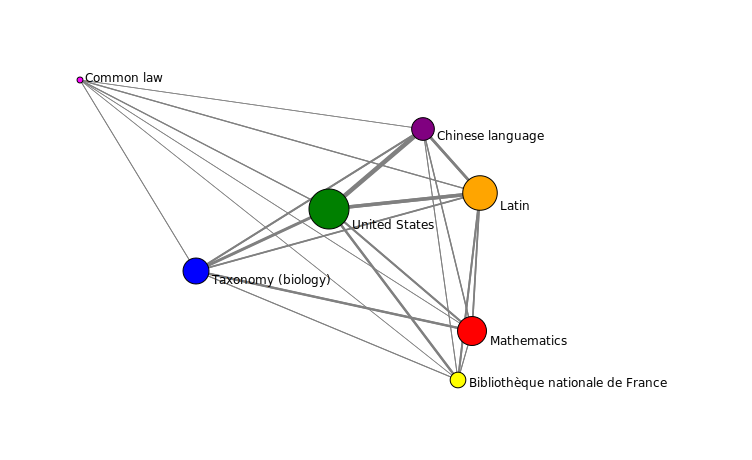

In [50]:
adjacency_aggregate = louvain.adjacency_
image = svg_graph(adjacency_aggregate, names=names[top_pages], labels=np.unique(labels), display_node_weight=True)
SVG(image)

## 3. Bigraphs

## Cinema

In [51]:
graph = cinema

In [52]:
biadjacency = graph.biadjacency
movies = graph.names_row
actors = graph.names_col

## To do

* Cluster the graph by Louvain (resolution 1). Use ``BiLouvain``.
* List the 10 largest clusters and display the names of the top-5 actors and top-5 movies of each cluster in terms of Personalized BiPageRank.

In [53]:
bilouvain = BiLouvain(resolution=1)
bilouvain.fit(biadjacency)
labels_row = bilouvain.labels_row_
labels_col = bilouvain.labels_col_

In [54]:
biadjacency_aggregate = bilouvain.biadjacency_
labels_unique_row, counts_row = np.unique(labels_row, return_counts=True)
labels_unique_col, counts_col = np.unique(labels_col, return_counts=True)

In [57]:
print(counts_row[top_k(counts_row,10)])
print(counts_col[top_k(counts_col,10)])

[17018 14442 11186  8190  7685  5657  4789  2802  2328  1071]
[10884  4488  4136  3850  3153  2262  1819  1563  1362   885]


In [58]:
v = biadjacency_aggregate.sum(axis=1).flatten()
int_degree = biadjacency_aggregate.diagonal()
strength_c = np.asarray(int_degree/v).flatten()
idx_max = top_k(strength_c, 10)

In [59]:
idx_max

array([261, 164,  70, 307, 153, 283, 140, 287, 132, 260])

In [154]:
strength_c

array([0.00581395, 0.02272727, 0.0625    , 0.015625  , 0.01282051,
       0.03125   , 0.04761905, 0.0625    , 0.04545455, 0.03846154,
       0.0625    , 0.14285714, 0.08333333, 0.125     , 0.05882353,
       0.05555556, 0.09090909, 0.14285714, 0.11111111, 0.11111111,
       0.2       , 0.2       , 0.1       , 0.11111111, 0.1       ,
       0.25      , 0.14285714, 0.2       , 0.07142857, 0.16666667,
       0.14285714, 0.25      , 0.09090909, 0.14285714, 0.14285714,
       0.14285714, 0.14285714, 0.25      , 0.16666667, 0.11111111,
       0.1       , 0.07692308, 0.33333333, 0.16666667, 0.2       ,
       0.16666667, 0.11111111, 0.16666667, 0.11111111, 0.11111111,
       0.07692308, 0.25      , 0.5       , 0.5       , 0.16666667,
       0.2       , 0.07692308, 0.14285714, 0.25      , 0.14285714,
       0.16666667, 0.125     , 0.14285714, 0.125     , 0.125     ,
       0.5       , 0.14285714, 0.25      , 0.25      , 0.16666667,
       0.1       , 1.        , 0.14285714, 0.2       , 0.25   

In [60]:
# Proposition
bipagerank = BiPageRank()
top_pages = []
for label in labels_unique_row:
    cluster = np.where(labels_row == label)[0]
    seeds = {node: 1 for node in cluster}
    scores = bipagerank.fit_transform(biadjacency, seeds)
    top_nodes = cluster[top_k(scores[cluster], 5)]
    print(top_nodes)
    print(movies[top_nodes], len(cluster))
    top_pages.append(top_nodes[0])

[78876 29166  6684 28790 82439]
['The Walking Dead (TV series)' 'House of Cards (U.S. TV series)'
 'Arrow (TV series)' 'Homeland (TV series)' 'Twin Peaks'] 17018
[49957 87955 67396 31436 46532]
['Paramount on Parade' 'Ziegfeld Follies' 'The Crusades' 'Intolerance'
 'Night Life in Hollywood'] 14442
[62825 34761 49387 45471 52881]
['Suyamvaram' 'Kerala Cafe' 'Paalayam' 'Naduvazhikal'
 'Puthukkottayile Puthumanavalan'] 11186
[41282 33663 63636 57507 25969]
['Many Kisses Later' 'Kaamelott' 'Tatort' 'Seances'
 'Gramps Is in the Resistance'] 8190
[12887 12914 50285   402 85590]
['Carry On (franchise)' 'Carry On Sergeant' 'Passport to Pimlico'
 '29 Acacia Avenue' "What's Up Superdoc!"] 7685
[65196 39635 58059 23009 31108]
['The Banquet (1991 film)' 'Lucky Stars' 'Seven Samurai'
 'Five Senses of Eros' 'Infernal Affairs (film series)'] 4789
[30645 36252 16792 17013 53198]
['Immaan Dharam' 'LOC Kargil' 'Darna Mana Hai' 'De Dana Dan' 'Raaj Tilak'] 5657
[18410 84421 18394 62142  3217]
['Die golden

[11132 16139 77651  3425 71616]
['Bosta' 'Curtains (1995 film)' 'The Sweet Hereafter' "Adam's Wall"
 'The Kite'] 41
[28318 20254 17636 85860 51216]
['Hillside Cannibals' 'Eating Out' 'Demon Under Glass'
 'When a Killer Calls' 'Pirates of Treasure Island'] 44
[73131 51582 67948 76528  1673]
['The Man from Snowy River (1920 film)' 'Pommy Arrives in Australia'
 'The Dinkum Bloke' 'The Sentimental Bloke' "A Maori Maid's Love"] 60
[44267 30608 48834 15145 38885]
['Mudhoney' 'Ilsa, Harem Keeper of the Oil Sheiks' 'Orgy of the Dead'
 'Common Law Cabin' 'Lorna'] 40
[ 7540 13692 84186 37165 15784]
['B.B. King \\u0022Into the Night\\u0022' 'Chatterbox (1977 film)'
 'Venice/Venice' 'Last Woman on Earth' 'Creature from the Haunted Sea'] 35
[61316 36780 28317  4843 24394]
['Stag Night of the Dead' 'Lady Godiva' 'Hillsborough' 'Amar Akbar & Tony'
 'Gadgetman'] 28
[33287 54512 88221 88132 88247]
['Julie Lescaut' 'Research unit' 'fr/Les Cordier, juge et flic'
 'fr/Camping Paradis' 'fr/Marc Eliot'] 24


[29587 10633 80775 70199  7247]
['Hurricane Bianca' 'Blubberella' 'Ticked-Off Trannies with Knives'
 'The Grief of Others' 'Auschwitz'] 6
[32809 34114 60829 32808 60830]
['Jikuu Senshi Spielban' 'Kamen Rider Black RX' 'Space Sheriff Shaider'
 'Jikuu Keisatsu Wecker' 'Space Sheriff Sharivan'] 8
[61120 46257 57452 63731 32884]
['Spring Break' 'Netherworld' 'Screwball Hotel' 'Teen Lust (1979 film)'
 'Jocks'] 6
[67002 48233 52792 22037 87519]
['The Commitments' 'Once' 'Purely Belter' 'Faintheart' 'You, Me & Marley'] 5
[58780 40603 45092 13752 49848]
['Shirome' 'Maku ga Agaru' 'My Pretend Girlfriend' 'Cheerfu11y'
 'Paper Flower'] 6
[88299 46482 88121 88284 88264]
['fr/Sur le fil (série télévisée)' 'Nicolas Le Floch (TV series)'
 'fr/Avocats et Associés' 'fr/Reporters (série télévisée)'
 'fr/Nos enfants chéris (série télévisée)'] 8
[13976 43825 35690 72593 21541]
['Children of Glory' 'Mother! The Mosquitoes' 'Kontroll'
 "The Lord's Lantern in Budapest" 'Európa expressz'] 7
[30549 59085 81624

[79322 14007 26286 76689 79916]
['The Wings' 'Children of the Streets' 'Guilt Redeemed'
 'The Ships That Meet' 'Therèse (1916 film)'] 6
[15178 60671 84946 26826 44694]
['Computer Chess' 'Sorry, Thanks' 'Waking Life' 'Hannah Takes the Stairs'
 'Mutual Appreciation'] 5
[1680 4614]
['A Martian Christmas' 'All the Way to the Ocean'] 2
[25401  8075 34763 84124]
['Gnanambika' 'Balan' 'Kerala Kesari' 'Vellinakshatram (1949 film)'] 4
[16248 13977 55660]
['Da Sweet Blood of Jesus' 'Children of God' 'Roxanne Roxanne'] 3
[25545 49644 19459 28166]
["Goin' Down the Road" 'Pale Rider' 'Down the Road Again' 'Hidden Places'] 4
[29490 27023 46475 14416]
['Human Target (1992 TV series)' 'Hard to Hold' 'Nick Knight'
 'Cigarettes & Coffee'] 4
[62008 14635 78167 23816 19238]
['Street Trash' "Class of Nuke 'Em High" 'The Toxic Avenger'
 'Frankenhooker' 'Doom Asylum'] 5
[36448 73951 13136 49556 83037]
['La Traviata (1983 film)' 'The Mystery of Dante'
 'Cavalleria rusticana (1982 film)' 'Pagliacci (1982 film)

[24283]
['Funny Things Happen Down Under'] 1
[22722]
['Final Exam'] 1
[53374]
['Rage (1999 film)'] 1


In [65]:
# Correction

bipagerank = BiPageRank()
for label in labels_unique_row:
    cluster_row = np.where(labels_row == label)[0]
    seeds_row = {node : 1 for node in cluster_row}
    bipagerank.fit(biadjacency, seeds_row)
    scores_row = bipagerank.scores_row_
    top_row = cluster_row[top_k(scores_row[cluster_row],5)]
    print(movies[top_row], len(cluster_row))

['The Walking Dead (TV series)' 'House of Cards (U.S. TV series)'
 'Arrow (TV series)' 'Homeland (TV series)' 'Twin Peaks'] 17018
['Paramount on Parade' 'Ziegfeld Follies' 'The Crusades' 'Intolerance'
 'Night Life in Hollywood'] 14442
['Suyamvaram' 'Kerala Cafe' 'Paalayam' 'Naduvazhikal'
 'Puthukkottayile Puthumanavalan'] 11186
['Many Kisses Later' 'Kaamelott' 'Tatort' 'Seances'
 'Gramps Is in the Resistance'] 8190
['Carry On (franchise)' 'Carry On Sergeant' 'Passport to Pimlico'
 '29 Acacia Avenue' "What's Up Superdoc!"] 7685
['The Banquet (1991 film)' 'Lucky Stars' 'Seven Samurai'
 'Five Senses of Eros' 'Infernal Affairs (film series)'] 4789
['Immaan Dharam' 'LOC Kargil' 'Darna Mana Hai' 'De Dana Dan' 'Raaj Tilak'] 5657
['Die goldene Stadt' 'Vienna Blood' 'Die Nibelungen' 'Stukas'
 'Abschied von den Wolken'] 2802
['La gran familia' 'Las chicas del cable' 'Hasta que el dinero nos separe'
 'Aquí no hay quien viva' 'El día de las madres'] 2328
['House Husbands' 'The Wannabes' 'Bad Eggs'

['Keye Luke' 'Only the Brave' 'Christmas Icetastrophe' 'Red Doors'
 'Ice Planet'] 18
['Beyond the Valley of the Dolls' 'Lemora' 'Terminal Island'
 'Attack of the 60 Foot Centerfold' 'Dolemite'] 23
['Rules of Love' 'The Stranger (video series)' 'The Confusion of Tongues'
 'The Great Dome Robbery' 'The Airzone Solution'] 19
['The Amazing Bulk' "Someone's Knocking at the Door" 'The System Within'
 'The Last Dragon' "Boss'n Up"] 25
['Sister Mary' 'Welcome to New York (2012 film)' 'Judas Kiss (2011 film)'
 'Schoolboy Crush' 'Moan'] 20
['fr/Cut !' 'fr/Foudre (série télévisée)' "fr/Les Filles d'à côté"
 "fr/Les Nouvelles Filles d'à côté" 'fr/Sous le soleil de Saint-Tropez'] 14
['Out the Gate' 'Dancehall Queen' 'Shottas' 'One Love (2003 film)'
 'StreetDance 3D'] 14
['Varannan vecka' 'The Anderssons in Greece'
 'The Anderssons Rock the Mountains' 'Rebellion (miniseries)'
 'Klassfesten'] 18
['Dead Kansas' 'Wrestlemaniac' 'Dahmer vs. Gacy'
 'Fear No Evil (1981 film)' 'Catacombs (1988 film)'] 23
[

['Closed for the Season' 'Christmas with the Dead' 'Broke Sky'
 'Dead Letters' 'Within the Rock'] 6
['Sea of Fear' 'Red Dirt Rising' 'Zombie Wars' 'Wesley'] 4
['1987' 'fr/Tactik' 'Mutants (2016 film)' 'Overpass' '1981'] 6
['24 Hours in the Past' 'Tyger Takes On...' 'Crapston Villas'] 3
['Cybergirl' 'Bloodmoon (1990 film)' 'Song of Songs (2005 film)'] 3
["Don't Play Us Cheap" 'The Jerk' "A Cantor's Tale" 'The Stoolie'] 4
['Celsius 41.11' 'The Fever (2004 film)' 'Fahrenheit 9/11' 'Michael & Me'
 'Michael Moore in TrumpLand'] 8
['Diese Drombuschs' 'Agathe kann’s nicht lassen' 'Familie Sonnenfeld'
 'Liebe, Babys und ein großes Herz'] 4
['Blue Eyes' 'I Travel Because I Have to, I Come Back Because I Love You'
 'Neighboring Sounds' 'Tatuagem' 'The Assailant'] 6
['The Adventure of Faustus Bidgood' 'The Straitjacket Lottery'
 'Ten for Grandpa' 'Cube Zero'] 4
['Star Trek Continues' 'Texas Night Train' 'Scream of the Banshee'] 3
['Vier Frauen und ein Todesfall' 'Contact High' 'Slugs (2004 film)'

['The Miserables'] 1
['Arctic Blast'] 1
['La estación de la Calle Olvera'] 1
['The First Grader' 'Hijack Stories'] 2
['Mindgame (Doctor Who)'] 1
['Underground (1976 film)' 'The Black Power Mixtape 1967–1975'] 2
['Monty Python Live at the Hollywood Bowl'] 1
['Floating Life'] 1
['Feet of Clay (2007 film)'] 1
['Slamma Jamma'] 1
['Last Night at the Alamo' "The Whole Shootin' Match"] 2
['Inertia'] 1
['The Inheritance (2007 film)' 'Dark Nature'] 2
['Labou'] 1
['Silent Night, Deadly Night'] 1
['I, Don Giovanni'] 1
['Together (2000 film)'] 1
['Tomboy (1985 film)'] 1
['Dreams on Spec'] 1
['Funny Things Happen Down Under'] 1
['Final Exam'] 1
['Rage (1999 film)'] 1


In [67]:
for label in labels_unique_col:
    cluster_col = np.where(labels_col == label)[0]
    seeds_col = {node : 1 for node in cluster_col}
    bipagerank.fit(biadjacency, seeds_col=seeds_col)
    scores_col = bipagerank.scores_col_
    top_col = cluster_col[top_k(scores_col[cluster_col],3)]
    print(actors[top_col], len(cluster_col))

['Eric Roberts' 'Danny Trejo' 'Donald Sutherland'] 10884
['William Boyd' 'John Wayne' 'Lionel Barrymore'] 4488
['Mammootty' 'Jagathy Sreekumar' 'Prakash Raj'] 2262
['Louis de Funès' 'Gérard Depardieu' 'Totò'] 3850
['Christopher Lee' 'Peter Cushing' 'John Stuart'] 4136
['Andy Lau' 'Simon Yam' 'Eric Tsang'] 3153
['Mithun Chakraborty' 'Dharmendra' 'Naseeruddin Shah'] 1819
['Hans Albers' 'Willy Fritsch' 'Paul Hörbiger'] 1362
['Sara García' 'Gaspar Henaine' 'Federico Luppi'] 1563
['Chris Haywood' 'John Jarratt' 'Bryan Brown'] 885
['Yevgeny Leonov' 'Leonid Kuravlyov' 'Georgy Vitsin'] 737
['Shakib Khan' 'Prosenjit Chatterjee' 'Soumitra Chatterjee'] 410
['Moe Howard' 'Larry Fine' 'Oliver Hardy'] 320
['Nora Aunor' 'Eddie Garcia' 'Eugene Domingo'] 578
['Mikael Persbrandt' 'Peter Haber' 'Poul Reichhardt'] 482
['Frank Welker' 'Kathleen Barr' 'Mel Blanc'] 583
['José Wilker' 'Glória Pires' 'Selton Mello'] 370
['Edvard Persson' 'Hasse Ekman' 'Gunnar Björnstrand'] 271
['Fabijan Šovagović' 'Mustafa Nad

['Dian Bachar' 'Toddy Walters' 'Trey Parker'] 4
['Dawid Ogrodnik' 'Tomasz Schuchardt' 'pl/Wojciech Zieliński (aktor)'] 5
['Tyler Collins' 'John McPhail (director)' 'Alison Peebles'] 5
['Damian Maffei' 'Joe Unger' 'Duane Whitaker'] 4
['Burgess Jenkins' 'Adam Mayfield' 'Brad Yoder'] 6
['Sandrine Bisson' 'Jean-Carl Boucher' 'Pier-Luc Funk'] 3
['Tyger Drew-Honey' 'Alistair McGowan' 'Zöe Lucker'] 6
['Christine Amor' 'Leon Lissek' 'Craig Horner'] 6
['Mabel King' 'Thomas Anderson' 'Rhetta Hughes'] 5
['Michael Moore'] 1
['Marion Kracht' 'Hans Peter Korff' 'Ruth Drexel'] 5
['Irandhir Santos' 'Erica Gimpel' 'Cristina Lago'] 3
['David Huband' 'Andy Jones (comedian)' 'Greg Malone'] 5
['Chuck Huber' 'Todd Haberkorn' 'Lydia Mackay'] 6
['Michael Ostrowski' 'de/Raimund Wallisch' 'Adele Neuhauser'] 4
['Melanie Winiger' 'Michael Koch (film director)' 'Carlos Leal'] 4
['John Giorno' 'Dick Cavett' 'Joan Juliet Buck'] 5
['André S. Labarthe' 'Sady Rebbot' 'Johnnie To'] 5
['Doug Stanhope' 'Tig Notaro' 'Jim J